In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from BNSeg.BNN_seg_src.data import get_dataloader
from BNSeg.BNN_seg_src.config import Config
from BNSeg.BNN_seg_src.op import vis_segments_CamVid
import os
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from BNSeg.BNN_seg_src.util import Checkpoint
from BNSeg.BNN_seg_src.model import Model
import torch.nn as nn

import ipywidgets
from ipywidgets import Layout
from ipywidgets import interact
import IPython


### Load Test Data
### If you find you do not have enough cuda memory you can set the device to cpu

In [3]:
current_path = os.getcwd()
config_instance = Config(current_path)
# config_instance.device = torch.device('cuda:{}'.format(config_instance.gpu)
#                      if torch.cuda.is_available() else 'cpu')
config_instance.device = torch.device('cpu')

In [4]:
print(config_instance.data_dir)
test_loader = get_dataloader(config_instance)
test_iter = iter(test_loader['test'])

./BNSeg/data/
==>>> total testing batch number: 8


### Show data example

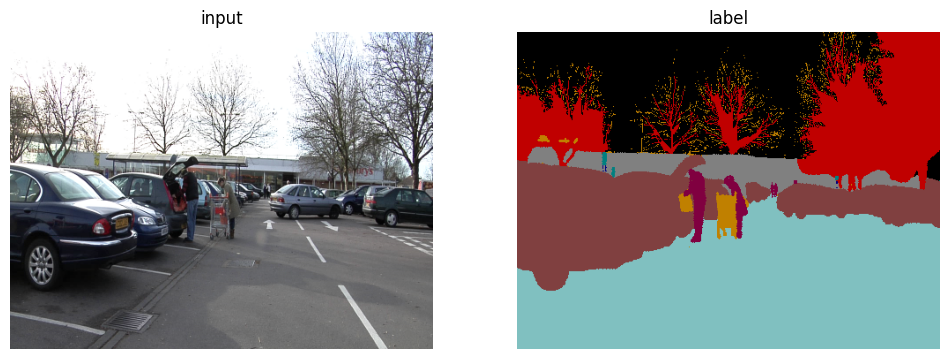

In [5]:
first_batch = next(iter(test_loader['test']))
# read image and label
image = first_batch['image']
label = first_batch['mask']

# class image to rgb image
label_imgs = vis_segments_CamVid(label.detach().cpu().numpy().astype(np.int64))

# unnormalize 
image = image[0].permute((1,2,0)).float().cpu().numpy() * 255

# int type for plt show
image = image.astype('uint8')
label_img = label_imgs[0]
label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)

# show example image
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.imshow(image)
ax1.axis('off')
ax1.set_title("input")
ax2.imshow(label_img)
ax2.axis('off')
ax2.set_title("label")
plt.show()

## prepared image path
imgs_save_path = './BNSeg/experiments/CamVid/combined_demo/save'
sample_name_list = ['prediction sample 1','prediction sample 2','prediction sample 3']
sample_num_list = [1,2,15,30]


### Load the model 

In [6]:
print("Loading model... ")
ensemble_list = ['ensemble_00','ensemble_01','ensemble_02','ensemble_03']
model_list = []
for model_name in ensemble_list:
    config_instance.exp_load = model_name
    config_instance.uncertainty = 'combined'
    combined_model = Model(config_instance)
    combined_check_point = Checkpoint(config_instance)
    combined_check_point.load() # load ckpt
    combined_model.load(combined_check_point, cpu=True if config_instance.device == torch.device('cpu') else False) # load model
    model_list.append(combined_model)

Loading model... 
Making model...
Making model...
Making model...
Making model...


In [7]:
 def inference_dropout(model, batch, sample_numer=15):
    with torch.no_grad():
        _input = batch['image']
        _label = batch['mask'] 
        _input = _input.to(config_instance.device)
        _label = _label.to(config_instance.device)

        model.eval()

        combined_results = model(_input, sample_numer)
        combined_pred_labels = torch.softmax(combined_results['mean'], dim=1).argmax(dim=1)
        sample_pred_list = []
        for i in range(3):
            sample_pred_i = torch.softmax(combined_results['sample_'+str(i)], dim=1).argmax(dim=1)
            sample_pred_i = vis_segments_CamVid(sample_pred_i.detach().cpu().numpy().astype(np.int64))
            sample_pred_i = cv2.cvtColor(sample_pred_i[0],cv2.COLOR_BGR2RGB)
            sample_pred_list.append(sample_pred_i)

        label_imgs = vis_segments_CamVid(_label.detach().cpu().numpy().astype(np.int64))
        combined_pred_imgs = vis_segments_CamVid(combined_pred_labels.detach().cpu().numpy().astype(np.int64))
        image = _input[0].permute((1,2,0)).float().cpu().numpy() * 255

        # heatmap
        e_var = (combined_results['e_var'][0].float().cpu().numpy() * 255).astype('uint8')
        a_var = (combined_results['a_var'][0].float().cpu().numpy() * 255).astype('uint8')
        heatmap_e_var = cv2.applyColorMap(e_var,cv2.COLORMAP_JET)
        heatmap_a_var = cv2.applyColorMap(a_var,cv2.COLORMAP_JET)  

        # int type for plt show
        image = image.astype('uint8')
        label_img = label_imgs[0]
        pred_img = combined_pred_imgs[0]
        label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)
        pred_img = cv2.cvtColor(pred_img,cv2.COLOR_BGR2RGB)
        heatmap_e_var =  cv2.cvtColor(heatmap_e_var,cv2.COLOR_BGR2RGB)
        heatmap_a_var =  cv2.cvtColor(heatmap_a_var,cv2.COLOR_BGR2RGB)
        
        return [image, label_img, pred_img, heatmap_a_var, heatmap_e_var,sample_pred_list]
    

def inference_ensemble(model_list, batch, sample_numer=15):
    def calc_entropy(input_tensor):
        lsm = nn.LogSoftmax(dim=1)
        log_probs = lsm(input_tensor) #
        probs = torch.exp(log_probs)
        p_log_p = log_probs * probs
        entropy = -p_log_p.mean(dim=1)
        return entropy
        
    with torch.no_grad():
        _input = batch['image']
        _label = batch['mask'] 
        _input = _input.to(config_instance.device)
        _label = _label.to(config_instance.device)

        
        mean_samples = []
        var_a_samples = []
        for model_i in model_list:
            model_i.eval()
            combined_results = model_i(_input, sample_numer)
            mean_samples.append(combined_results['mean'])
            var_a_samples.extend(combined_results['var_a_samples'])
            
        mean_pred = torch.stack(mean_samples, dim=0).mean(dim=0)
        combined_pred_labels = torch.softmax(mean_pred, dim=1).argmax(dim=1)
        e_std = torch.stack(mean_samples, dim=0).std(dim=0) 

        e_high = calc_entropy(mean_pred+e_std)
        e_low = calc_entropy(mean_pred-e_std)
        e_var = torch.abs(e_high - e_low)
        e_var = e_var/0.2071 #maximal entropy assume all output uniform distrbution

        a_var = torch.stack(var_a_samples, dim=0).mean(dim=0) #  B X C X H x W
        a_std = torch.sqrt(a_var)
        a_high = calc_entropy(mean_pred+a_var)
        a_low = calc_entropy(mean_pred-a_var)
        a_var = torch.abs(a_high - a_low)
        a_var = a_var/0.2071 #maximal entropy assume all output uniform distrbution
        
        sample_pred_list = []
        for i in range(3):
            sample_pred_i = torch.softmax(mean_samples[i], dim=1).argmax(dim=1)
            sample_pred_i = vis_segments_CamVid(sample_pred_i.detach().cpu().numpy().astype(np.int64))
            sample_pred_i = cv2.cvtColor(sample_pred_i[0],cv2.COLOR_BGR2RGB)
            sample_pred_list.append(sample_pred_i)

        label_imgs = vis_segments_CamVid(_label.detach().cpu().numpy().astype(np.int64))
        combined_pred_imgs = vis_segments_CamVid(combined_pred_labels.detach().cpu().numpy().astype(np.int64))
        image = _input[0].permute((1,2,0)).float().cpu().numpy() * 255

        # heatmap
        e_var = (e_var[0].float().cpu().numpy() * 255).astype('uint8')
        a_var = (a_var[0].float().cpu().numpy() * 255).astype('uint8')
        heatmap_e_var = cv2.applyColorMap(e_var,cv2.COLORMAP_JET)
        heatmap_a_var = cv2.applyColorMap(a_var,cv2.COLORMAP_JET)  

        # int type for plt show
        image = image.astype('uint8')
        label_img = label_imgs[0]
        pred_img = combined_pred_imgs[0]
        label_img = cv2.cvtColor(label_img,cv2.COLOR_BGR2RGB)
        pred_img = cv2.cvtColor(pred_img,cv2.COLOR_BGR2RGB)
        heatmap_e_var =  cv2.cvtColor(heatmap_e_var,cv2.COLOR_BGR2RGB)
        heatmap_a_var =  cv2.cvtColor(heatmap_a_var,cv2.COLOR_BGR2RGB)
        
        return [image, label_img, pred_img, heatmap_a_var, heatmap_e_var,sample_pred_list]





### Interactive model

In [8]:

def bnn_seg_interact_dropout(num_samples, image_num):
    
    def get_image_batch(image_num):
        for batch_index, batch in enumerate(test_loader['test']):
            if batch_index+1 == image_num:
                return batch
    
    def plot_difference(results): # hange it to show the sampled instance segmentation
        fig3, axs3 = plt.subplots(1,3,figsize=(11,3))
        sample_pred_list = results[-1]

        for col_j,j in enumerate(sample_name_list):
            axs3[col_j].imshow(sample_pred_list[col_j])
            axs3[col_j].set_xticks([])
            axs3[col_j].set_yticks([])               
            axs3[col_j].set_xlabel(j)
        return fig3
  
        

    def plot_results(results):
        # plot results after inference
        plt.close()
        
        fig1, ax = plt.subplots(1,figsize=(14,8))
        ax.imshow(results[0])
        ax.axis('off')
        ax.set_title("Input Image")
                
        fig2, axs = plt.subplots(2,2,figsize=(11,8))

        axs[0,0].imshow(results[1])
        axs[0,0].axis('off')
        axs[0,0].set_title("Ground Truth")
        axs[0,1].imshow(results[2])
        axs[0,1].axis('off')
        axs[0,1].set_title("Semantic Segmentation")        
        axs[1,0].imshow(results[3])
        axs[1,0].axis('off')
        axs[1,0].set_title("Aleatoric Uncertainty")  
        axs[1,1].imshow(results[4])
        axs[1,1].axis('off')
        axs[1,1].set_title("Epistemic Uncertainty")  
        
        # save 
        fig3 = plot_difference(results)
        fig3.show()

    image_batch = get_image_batch(image_num)
    results = inference_dropout(model_list[0],image_batch,num_samples)
    plot_results(results)
    

interact(bnn_seg_interact_dropout,
        num_samples=ipywidgets.IntSlider(value=15,min=4, max=50, continuous_update=False,
        description='Sample number of models', style={'description_width': 'initial'},layout=Layout(width='500px')),
        image_num=ipywidgets.IntSlider(value=1,min=1, max=8, continuous_update=False,
        description='Image index', style={'description_width': 'initial'})
        );

interactive(children=(IntSlider(value=15, continuous_update=False, description='Sample number of models', layo…

In [9]:

def bnn_seg_interact_ensemble(num_samples, image_num):
    
    def get_image_batch(image_num):
        for batch_index, batch in enumerate(test_loader['test']):
            if batch_index+1 == image_num:
                return batch
    
    def plot_difference(results): # hange it to show the sampled instance segmentation
        fig3, axs3 = plt.subplots(1,3,figsize=(11,3))
        sample_pred_list = results[-1]

        for col_j,j in enumerate(sample_name_list):
            axs3[col_j].imshow(sample_pred_list[col_j])
            axs3[col_j].set_xticks([])
            axs3[col_j].set_yticks([])               
            axs3[col_j].set_xlabel(j)
        return fig3
  
        

    def plot_results(results):
        # plot results after inference
        plt.close()
        
        fig1, ax = plt.subplots(1,figsize=(14,8))
        ax.imshow(results[0])
        ax.axis('off')
        ax.set_title("Input Image")
                
        fig2, axs = plt.subplots(2,2,figsize=(11,8))

        axs[0,0].imshow(results[1])
        axs[0,0].axis('off')
        axs[0,0].set_title("Ground Truth")
        axs[0,1].imshow(results[2])
        axs[0,1].axis('off')
        axs[0,1].set_title("Semantic Segmentation")        
        axs[1,0].imshow(results[3])
        axs[1,0].axis('off')
        axs[1,0].set_title("Aleatoric Uncertainty")  
        axs[1,1].imshow(results[4])
        axs[1,1].axis('off')
        axs[1,1].set_title("Epistemic Uncertainty")  
        
        # save 
        fig3 = plot_difference(results)
        fig3.show()

    image_batch = get_image_batch(image_num)

    results = inference_ensemble(model_list,image_batch,num_samples)
        
    plot_results(results)
    

interact(bnn_seg_interact_ensemble,
        num_samples=ipywidgets.IntSlider(value=15,min=4, max=50, continuous_update=False,
        description='Sample number of models', style={'description_width': 'initial'},layout=Layout(width='500px')),
        image_num=ipywidgets.IntSlider(value=1,min=1, max=8, continuous_update=False,
        description='Image index', style={'description_width': 'initial'})
        );

interactive(children=(IntSlider(value=15, continuous_update=False, description='Sample number of models', layo…

## Demo Guide:

#### some explanation
This demo base on the lieature of [What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?](https://arxiv.org/abs/1703.04977) and [repository](https://github.com/hmi88/what). We change the task to semantic segmentation as you saw in the course slides.

In the demo you can see the heatmap of aleatoric uncertainty and epistemic uncertainty. Note that the uncertainty is normalized so you can only the relative uncertainy in each of images. (The brighter place with greater uncertainty).

In short, aleatoric uncertainty measures what you can't understand from the data. It can be explained away with the ability to observe all explanatory variables with increased precision. Epistemic uncertainty measures what your model doesn't know due to lack of training data. It can be explained away with infinite training data. Think of epistemic uncertainty as model uncertainty [Blog](https://github.com/kyle-dorman/bayesian-neural-network-blogpost).

There are actually two types of aleatoric uncertainty, heteroscedastic and homoscedastic. It is obvious that for segmentation task we should use the heteroscedastic model since for different input the uncertainty is different.

- Sample number of model: The number of Monte Carlo samples we use to sample the epistemic uncertainy from different model samples. (Note that if you sample a lot of model it will be very slow especailly when you only use cpu, try start with a small sample numbers)
- Image index: we provide 8 different images for visualization

We use the CamVid dataset which was annotated with 12 different classes.(void, sky, building, TrafficCone, road, sidewalk, tree, sign, fence, car, Pedestrian, Bicycle)
If you 
                    
#### play around
- See how the epistemic uncertainty change by increasing or decreasing the epistemic sample number
- Think about in the image 1 and 2 what does the heat map probably mean? Why we have more aleatoric uncertainty on the human body?
- Think about in the image 4 what does the heat map probably mean? Why we have more aleatoric uncertainty on the notice bulletin board?
- Think about in the image 5 and 7 how could we use the uncertainty of the bicycle? When should you trust you prediction in autonomous driving?
- Think about in the image 6 do you think the prediction is right or not? what do you think the uncertainty might rbe used in the occlusion case? 
- Think anout in the image 8 why there is large epistemic uncertainty on the way? 

#### Moreover
If you are also interested in the training process or you would like to train your own model. You can find the code [here](https://github.com/qimaqi/BNN_Seg). If you find it useful do not forget to leave a star!
